# covarying neighborhood analysis: a demo

This notebook demonstrates the basic use of the `cna` python package. Before you run it, make sure you either install `cna` by running `pip install cna` or by cloning the `cna` github repo and adding it to your python path. (In the latter case you'll likely need to manually install the `multianndata` package, which is a dependency of `cna`.)

In [1]:
%%capture --no-stdout
import numpy as np
import matplotlib.pyplot as plt
import cna
np.random.seed(0)

## 1. minimal working example

Let's first see how to run `cna` and visualize results for a dataset that's already been appropriately prepared. You can learn more about data pre-processing and formatting in Section 2.

qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 16.050081575691678
	taking step 2
	median kurtosis: 12.740420558616929
	taking step 3
	median kurtosis: 6.164686377925819
	taking step 4
	median kurtosis: 3.2183676785797264
stopping after 4 steps
throwing out neighborhoods with batch kurtosis >= 6
keeping 10000 neighborhoods
covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median batch kurtosis =  1.9697975688203637
computing SVD
performing association test


/data/srlab1/yakir/py/cna/cna/tools/_association.py:71: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs


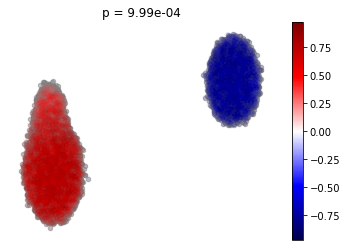

In [2]:
# read in toy dataset
d = cna.read('data.h5ad')

# perform association test for case/ctrl status, controlling for sex as a covariate and accounting for potential batch effect
res = cna.tl.association(d,                   #dataset
            d.samplem.case,                   #sample-level attribute of intests (case/control status)
            covs=d.samplem[['male']],         #covariates to control for (in this case just one)
            batches=d.samplem.batch)          #batch ids for each sample so that cna can account for batch effect

# visualize the results
cna.pl.umap_ncorr(d,                           #dataset
            res,                               #cna results object
            scatter0={'alpha':0.5, 's':20},    #plotting parameters for neighborhoods that pass FDR
            scatter1={'alpha':0.05, 's':20})   #plotting parameters for neighborhoods that don't pass FDR
plt.title('p = {:.2e}'.format(res.p))
plt.show()

In the plot above, each cell is colored according to its neighborhood coefficient. I.e., color corresponds to the correlation of each cell's corresponding neighborhood to case/control status. Neighborhoods that don't pass FDR 5% are shown in gray. As this plot shows, cases have a greater abundance of cells from the left-hand cluster relative to controls.

Let's next perform an association test for male/female sex rather than case/control status...

covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median batch kurtosis =  1.9775735288447418
computing SVD
performing association test
computing neighborhood-level FDRs


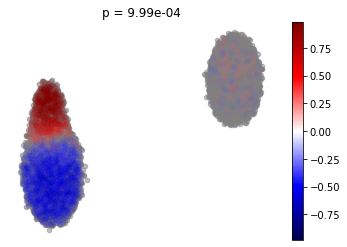

In [3]:
# perform association test for male/female sex, controlling for case/control status as a covariate and accounting for potential batch effect
res = cna.tl.association(d, d.samplem.male, covs=d.samplem[['case']], batches=d.samplem.batch)

# visualize the results
cna.pl.umap_ncorr(d, res,
            scatter0={'alpha':0.5, 's':20},
            scatter1={'alpha':0.05, 's':20})
plt.title('p = {:.2e}'.format(res.p))
plt.show()

It's now clear that a sub-population of the left-hand cluster is more abundant in males. CNA automatically picked up on this without needing to be given a resolution parameter.

Note that it looks like some cells in the right-hand cluster pass our FDR threshold of 5%. However, these cells comprise only ~6% of the cells that pass the threshold and so are likely false discoveries.

## 2. processing data into the correct format

Let's now see how to take an arbitrary dataset and process into the format required by `cna`. This format is a python object called `MultiAnnData`, which is a derivative of the common `AnnData` object used by `scanpy` that is modified to explicitly accommodate multi-sample single-cell datasets by including sample-level metadata.

In [4]:
#let's first convert our toy dataset above into a raw data set (with metadata stored per cell rather then per-sample, as is common)

# construct raw expression matrix: X
X = d.X

# contstruct pandas DataFrame for cell metadata: cell_meta
cell_meta = d.obs

# place sample-level metadata inside the cell metadata table to match how multi-sample data are often stored
sampleXmeta = d.samplem
cell_meta['batch'] = np.repeat(d.samplem.batch.values, 200)
cell_meta['case'] = np.repeat(d.samplem.case.values, 200)
cell_meta['male'] = np.repeat(d.samplem.male.values, 200)
del sampleXmeta

Let's take a quick look at `cell_meta`.

**Notice that in addition to the cell-level covariates `[batch, case, male]`, cell_meta also has a column named 'id' that says which sample each cell belongs to.**

In [5]:
cell_meta

,id,batch,case,male
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
9995,49,4,1,1
9996,49,4,1,1
9997,49,4,1,1
9998,49,4,1,1


and let's take a look at the raw expression matrix `X`, which is just a numpy array of samples by genes

In [6]:
X

array([[-1.6730515 ,  1.2498442 , -0.67010766, ...,  0.9319579 ,
        -0.11742914,  1.0834249 ],
       [ 2.655976  ,  4.384501  ,  0.8812876 , ...,  1.4578147 ,
        -0.5143964 ,  0.13931611],
       [ 1.0526824 ,  0.45784792,  0.79990184, ...,  0.25198448,
        -1.5550292 , -0.12520057],
       ...,
       [ 1.0130087 ,  2.1205258 ,  0.605871  , ...,  1.4236035 ,
         1.0399356 ,  1.3520845 ],
       [ 0.9772267 ,  1.4952078 , -0.11862092, ...,  0.12846321,
         0.18718313, -1.34924   ],
       [ 2.7493372 ,  0.8457265 ,  1.8954599 , ..., -0.41905   ,
         0.08695432, -0.8370467 ]], dtype=float32)

We'll now convert our data into `MultiAnnData` object and compute a UMAP nearest-neighbor graph on it so that it can be used with `cna`

In [7]:
import multianndata as mad

# initialize MultiAnnData object
# IMPORTANT: this is where we tell MultiAnnData which column of cell_meta corresponds to sample id
d = mad.MultiAnnData(X=X,            #expression matrix
                     obs=cell_meta,  #cell metadata matrix (pandas DataFrame)
                     sampleid='id')  #name of column of cell_meta that contains sample id for each cell

# now copy the cell-level metadata into sample-level metadata
d.obs_to_sample(['batch', 'case', 'male'])

Now `d` is a `MultiAnnData` object with several properties: like with normal `AnnData` objects, `X` still stores the raw expression data and `d.obs` stores cell-level information, etc. However, `d` also has the property `d.samplem` which stores sample-level meatadata. (Someday this should probably be renamed `d.sample` since it's analogous to `d.obs`.)

In [8]:
d.samplem.head()

,batch,case,male
id,,,
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0


The last pre-processing step to compute before we run `cna` is to compute a cell-cell similarity graph. Here we'll use `scanpy` to compute the standard UMAP similarity graph. (In principle, any graph can be computed here.)

In [9]:
%%capture --no-stdout
import scanpy as sc

# compute the UMAP cell-cell similarity graph
sc.pp.neighbors(d)

# compute UMAP coordinates for plotting
sc.tl.umap(d)

# the following line would save the pre-processed data as a h5ad file
# d.write('test.h5ad')

## 3. additional `cna` features

### 3.1 additional results produced by `association` function

Let's re-do the `cna` analysis and go over the results in more detail

In [10]:
d = cna.read('data.h5ad')
res = cna.tl.association(d, d.samplem.case, covs=d.samplem[['male']], batches=d.samplem.batch)

qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 16.050081575691678
	taking step 2
	median kurtosis: 12.740420558616929
	taking step 3
	median kurtosis: 6.164686377925819
	taking step 4
	median kurtosis: 3.2183676785797264
stopping after 4 steps
throwing out neighborhoods with batch kurtosis >= 6
keeping 10000 neighborhoods
covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median batch kurtosis =  1.9697975688203637
computing SVD
performing association test


/data/srlab1/yakir/py/cna/cna/tools/_association.py:71: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs


The `res` object returned by the association function contains the following fields:
1. `p` is the global p-value for association
1. `k` is the number of NAM PCs used for the association test (automatically selected in a data-dependent way)
1. `ncorrs` is the vector of neighborhood coefficients
1. `fdr_10p_t` and `fdr_5p_t` contain the thresholds on `np.abs(ncorrs)` needed to provide FDRs of 10% and 5% respectively
1. `fdrs` contains information on neighborhood-level FDRs at other thresholds
1. `kept` is a boolean vector that specifies which cells passed qc. So, e.g., `ncorrs` is of length `kept.sum()`.
1. `r2` is the global prediction r-squared achieved by the model
1. `r2_perpc` is the prediction r-squared achieved by each pc on its own
1. `beta` is the coefficient vector, one coefficient per PC
1. `yresid` and `yresid_hat` are the phenotype and the predicted phenotype, both with covariates and batch residualized out

The kurtosis numbers in the output above say how 'outlier-y' the neighborhood abundances are at each step in the diffusion that `cna` does to define its neighborhoods. The algorithm stops when these numbers stop going down quickly. But if you see that `cna` stops when kurtosis is still very high (like above 10), that's likely a sign that the data aren't qc'd properly or are otherwise unsuitable.

### 3.2 working directly with the NAM and NAM PCs

The association function above also automatically computes the NAM and its SVD as a prerequisite to the association testing. These can be found in the following objects
1. `d.uns['NAM.T']` contains the transpose of the NAM (neighborhoods by samples)
1. `d.uns['NAM_sampleXpc']` contains the sample loadings of the principal components of the NAM
1. `d.uns['NAM_nbhdXpc']` contains the neighborhood loadings of the principal components of the NAM
1. `d.uns['NAM_svs']` contains the squared singular values of the NAM

These objects can also be computed independent of any association test using the function `cna.tl.nam`, demonstrated below

In [11]:
cna.tl.nam(d, batches=d.samplem.batch) #note: this NAM is being computed *without* adjusting for sex or case/ctrl status

covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median batch kurtosis =  1.9775735288447418
computing SVD


Let's visualize a few of the results...

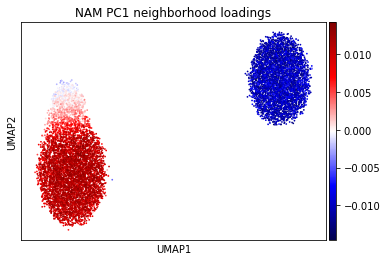

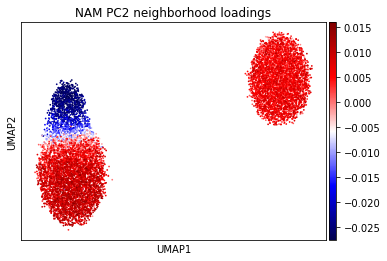

In [12]:
#plot neighborhood loadings of NAM PC 1
d.obs['NAMPC1'] = np.nan
d.obs.loc[d.uns['keptcells'], 'NAMPC1'] = d.uns['NAM_nbhdXpc'].PC1
sc.pl.umap(d, color='NAMPC1', cmap='seismic', title='NAM PC1 neighborhood loadings')
plt.show()

#plot neighborhood loadings of NAM PC 2
d.obs['NAMPC2'] = np.nan
d.obs.loc[d.uns['keptcells'], 'NAMPC2'] = d.uns['NAM_nbhdXpc'].PC2
sc.pl.umap(d, color='NAMPC2', cmap='seismic', title='NAM PC2 neighborhood loadings')
plt.show()

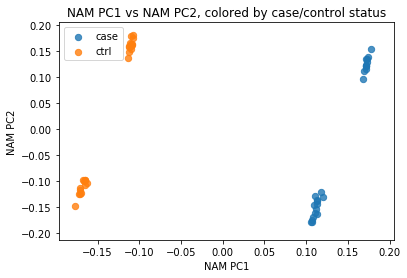

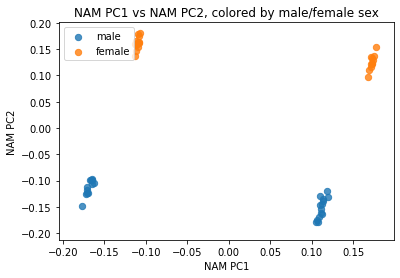

In [13]:
def sample_loading_plot_by_binary_pheno(pheno, case_label, ctrl_label): #assumes pheno is binary
    pcs = d.uns['NAM_sampleXpc']
    cases = pheno.astype(np.bool)
    plt.scatter(pcs.loc[cases].PC1, pcs.loc[cases].PC2, s=40, alpha=0.8, label=case_label)
    plt.scatter(pcs.loc[~cases].PC1, pcs.loc[~cases].PC2, s=40, alpha=0.8, label=ctrl_label)
    plt.legend()
    plt.xlabel('NAM PC1')
    plt.ylabel('NAM PC2')

#plot sample loadings of NAM PC1 versus NAM PC2, colored by case/control status
sample_loading_plot_by_binary_pheno(d.samplem.case, 'case', 'ctrl')
plt.title('NAM PC1 vs NAM PC2, colored by case/control status')
plt.show()

#plot sample loadings of NAM PC1 versus NAM PC2, colored by male/female sex
sample_loading_plot_by_binary_pheno(d.samplem.male, 'male', 'female')
plt.title('NAM PC1 vs NAM PC2, colored by male/female sex')
plt.show()

You can see in these plots that NAM PC 1 roughly corresponds to case/control status and NAM PC1 roughly corresponds to sex.

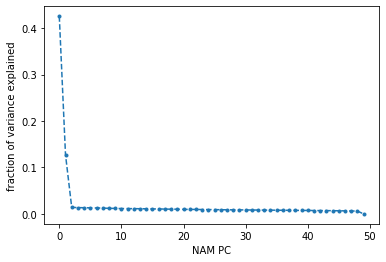

In [19]:
# plot variance explained by each NAM PC
plt.plot(d.uns['NAM_svs']/d.uns['NAM_svs'].sum(), marker='.', linestyle='--')
plt.xlabel('NAM PC')
plt.ylabel('fraction of variance explained')
plt.show()

As this plot demonstrates, PC1 explains ~40% of the variance in the dataset, PC2 explains ~12%, and the rest really don't contribute much.